## Imports and Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cpu


## Dataset Class

In [2]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        else:
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

## Create Datasets

In [3]:
from torch.utils.data import ConcatDataset
import os

MVTEC_ROOT = "./Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


TRAINING IMAGES


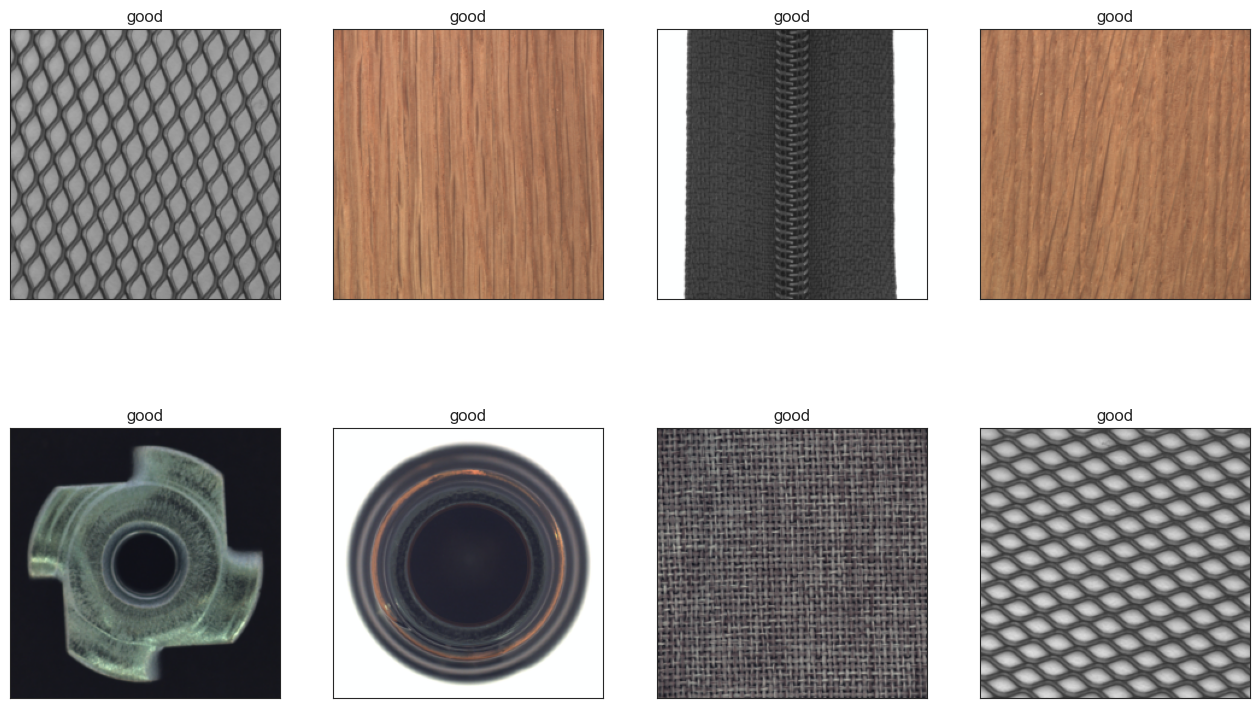

TESTING IMAGES


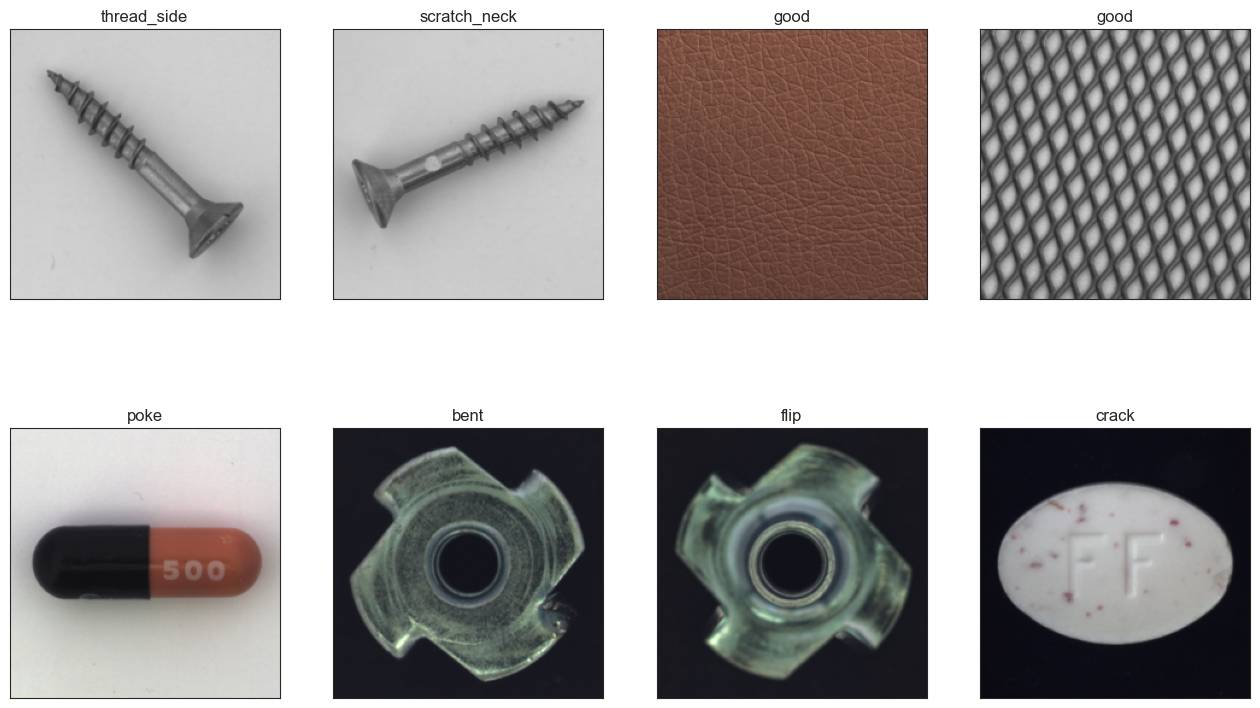

In [4]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)

## Embed training features, compare to Test data and draw conclusion

In [5]:
EMBEDDING_FILE_EXT = "embeddings.npz"

def save_embeddings_compressed(embeddings, save_path="./embeddings", dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Separate embeddings and labels
    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    # Save as compressed numpy
    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"✓ Compressed embeddings saved to: {npz_path}")
    print(f"  File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]
    labels = data["labels"]

    # Convert to list of tuples
    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(f"✓ Loaded {len(embeddings)} embeddings")

    return embeddings

In [9]:
def embed_and_save_features(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m"
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            # ---- PATCH TOKEN EXTRACTION (best for accuracy) ----
            if isinstance(feats, dict):
                x = feats.get("x_norm")  # (B, num_patches, 384)
            else:
                x = feats  # fallback

            # ---- MEAN POOL OVER PATCHES (optimal) ----
            emb = x.abs().max(dim=1).values  # (B, 384)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split)
    return embeddings

In [10]:
import csv 
def cosine_sim_matrix(test_vec, gt_mat):
    """
    test_vec: (384,)
    gt_mat:   (N, 384)
    returns:  (N,)
    """
    return (gt_mat @ test_vec).ravel()  # already normalized


def compare_and_draw_conclusion(
    threshold=0.8, rank=10, csv_path="results.csv", embedding_folder="./embeddings"
):
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

    embeddings_GT = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train")
    )

    embeddings_Test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test")
    )

    gt_vecs, _ = zip(*embeddings_GT)
    gt_mat = np.asarray(gt_vecs, dtype=np.float32)

    # Normalize GT matrix once
    gt_mat /= np.linalg.norm(gt_mat, axis=1, keepdims=True) + 1e-8

    results = []
    correct = 0
    total = 0

    for idx, (test_vec, label) in enumerate(embeddings_Test):

        tv = np.asarray(test_vec, dtype=np.float32)
        tv /= np.linalg.norm(tv) + 1e-8

        sims = cosine_sim_matrix(tv, gt_mat)  # vectorized

        # select rank-th highest similarity
        kth = np.partition(sims, -rank)[-rank] if len(sims) >= rank else sims.max()

        pred = "good" if kth > threshold else "anomalous"
        true = "good" if str(label).lower() == "good" else "anomalous"

        ok = int(pred == true)
        correct += ok
        total += 1

        results.append(
            {
                "Test_Index": total,
                "True_Label": true,
                "Predicted_Label": pred,
                f"{rank}th_Best_Similarity": kth,
                "Correct": ok,
            }
        )

    acc = correct / total if total else 0

    results.append(
        {
            "Test_Index": "TOTAL",
            "True_Label": "",
            "Predicted_Label": "",
            f"{rank}th_Best_Similarity": "",
            "Correct": f"{acc*100:.2f}% ({correct}/{total})",
        }
    )

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Saved: {csv_path}")
    return acc

In [11]:
# on GPU it takes roughly 3 minutes 18s to process all training and testing embeddings

compare_and_draw_conclusion(threshold=0.99, rank=7)

Processed 10 batches
Processed 20 batches
Processed 30 batches
Processed 40 batches


KeyboardInterrupt: 